# Kaggle Project1: Give Me Some Credit
------------------------------------------------------------------------

**Objective**: Improve credit scoring by predicting the probability that somebody will experience financial distress in the next two years.

### Features:
---------------

**SeriousDlqin2yrs** – Target Value, indicates whether someone has experienced some past due delinquency 

by 90 days or worse (1/0 – True/False)

**RevolvingUtilizationOfUnsecuredLines** –  (Total balance on credit cards + personal lines of credit) / Sum of credit limits

(Does not include real estate and installment debt like car loans) (Percentage)

**age** – Age in years of the person borrowing (Integer)

**NumberOfTime30-59DaysPastDueNotWorse** – This is the number of times the person borrowing has 

been late on making a payment by 30-59 days but no worse in the last 2 years (Integer)

**DebtRatio** – Monthly debt payments + alimony + living costs⁄monthly gross income (Percentage)

**MonthlyIncome** – This the merely the monthly income of the particular borrower (Integer)

**NumberOfOpenCreditLinesAndLoans** – The number of open loans (car/mortgage loans) and lines of 

credit (credit cards, etc.) one has (Integer)

**NumberOfTimes90DaysLate** – This is the number of times one has been 90 days or more past due 

(Integer)

**NumberRealEstateLoansOrLines** – This is the number of real estate and mortgage loans one has; this 

includes home equity lines of credit. (Integer)

**NumberOfTime60-89DaysPastDueNotWorse** – This is the number of times the person borrowing has 

been late on making a payment by 60-89 days but no worse in the last 2 years (Integer)

**NumberOfDependents** – This value is merely the number of dependents one has; this includes 

themselves, spouse, children, etc. (Integer)

In [27]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [28]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [29]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# get ready for plots
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [30]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [31]:
# remove duplicates, check data type and metrics
train_data = pd.read_csv("Train_Data_Credit.csv").drop_duplicates()
train_data.drop(train_data.columns[0],1,inplace=True)
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
1,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
2,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
3,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
4,0,0.907239,49,1,0.024926,63588,7,0,1,0,0


Start with exploratory analysis

In [32]:
train_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,120269.000000,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6670.221237,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,14384.674215,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3400.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8249.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3008750.000000,58.000000,98.000000,54.000000,98.000000,20.000000


In [33]:
train_data[train_data.SeriousDlqin2yrs==1].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,10026,10026.000000,10026.000000,10026.00000,10026.000000,8357.000000,10026.000000,10026.000000,10026.000000,10026.000000,9847.000000
mean,1,4.367282,45.926591,2.38849,295.121066,5630.826493,7.882306,2.091362,0.988530,1.828047,0.948208
std,0,131.835778,12.916289,11.73451,1238.360283,6171.719674,5.653601,11.762760,1.425723,11.753068,1.219367
min,1,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1,0.398219,36.000000,0.00000,0.193979,2963.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,1,0.838853,45.000000,0.00000,0.428227,4500.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,1,1.000000,54.000000,2.00000,0.892371,6800.000000,11.000000,1.000000,2.000000,1.000000,2.000000
max,1,8328.000000,101.000000,98.00000,38793.000000,250000.000000,57.000000,98.000000,29.000000,98.000000,8.000000


There seems to be no relationship between missing data and serious deliquency, while **NumberOfTimes90DaysLate** and **NumberOfTime60-89DaysPastDueNotWorse** has significantly higher mean and stdev. Also, we can find that nearly every of the column's max value is much greater than it's 75% percentile's value. We will take care of it later.

The next thing is to take a look at the outliers and missing data. Simply using the same method on the data frame filtered by more than 75 percentile we can find that revolving utilization of lines and late payment are strong indicators of future delinquency. Since the rows outliers do provide information, it is better we keep it. Columns of **MonthlyIncome** and **NumberOfDependent** have the missing data, but having no value itself seems to have no relationship with future delinquency. Thus we simply impute the missing data with median.

In [34]:
train_data[train_data['RevolvingUtilizationOfUnsecuredLines']>1].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,2773.000000,3321.000000,3321.000000,3321.000000,3321.00000,3260.000000
mean,0.372478,259.773362,44.055405,1.016260,245.169459,5289.567977,6.373683,0.637760,0.682023,0.43240,0.917791
std,0.483538,1659.034074,12.655322,1.355169,939.844850,5134.134472,4.033118,1.325063,0.973476,0.85219,1.197826
min,0.000000,1.000059,21.000000,0.000000,0.000800,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.019996,34.000000,0.000000,0.180627,2700.000000,3.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,1.074633,43.000000,1.000000,0.374304,4184.000000,6.000000,0.000000,0.000000,0.00000,0.000000
75%,1.000000,1.301096,52.000000,2.000000,0.806048,6458.000000,8.000000,1.000000,1.000000,1.00000,2.000000
max,1.000000,50708.000000,88.000000,10.000000,21395.000000,141500.000000,40.000000,15.000000,10.000000,7.00000,8.000000


In [35]:
train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse']>2].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,3351.000000,3351.000000,3351.000000,3351.000000,3351.000000,2804.000000,3351.000000,3351.000000,3351.000000,3351.000000,3290.000000
mean,0.404954,0.721661,48.310057,11.317816,368.250268,6452.858417,9.590570,8.405849,1.157266,8.411817,0.966565
std,0.490956,0.582860,12.454441,25.625434,1332.685116,6850.723118,5.695305,26.484995,1.436842,26.477496,1.198499
min,0.000000,0.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.415887,40.000000,3.000000,0.229704,3376.500000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.836484,48.000000,3.000000,0.437643,5352.000000,9.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,56.500000,5.000000,0.806898,7845.500000,13.000000,1.000000,2.000000,1.000000,2.000000
max,1.000000,14.540918,96.000000,98.000000,32843.000000,234600.000000,49.000000,98.000000,26.000000,98.000000,7.000000


In [36]:
train_data[train_data['NumberOfTimes90DaysLate']>0].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,6725.000000,8338.000000,8338.000000,8338.000000,8338.000000,8154.000000
mean,0.416407,4.407480,45.989446,4.124250,235.540638,5179.998810,5.904294,4.784840,0.635284,3.622451,0.899191
std,0.492992,233.037458,13.161935,17.187293,858.979591,5765.481506,4.809576,17.062571,0.984825,17.248188,1.223123
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.489210,36.000000,0.000000,0.122294,2751.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.946948,46.000000,1.000000,0.323627,4150.000000,5.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,55.000000,2.000000,0.772150,6250.000000,8.000000,2.000000,1.000000,1.000000,2.000000
max,1.000000,20514.000000,97.000000,98.000000,21727.000000,234600.000000,42.000000,98.000000,26.000000,98.000000,20.000000


In [37]:
train_data[train_data['NumberOfTime60-89DaysPastDueNotWorse']>0].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,7604.000000,7604.000000,7604.000000,7604.000000,7604.000000,6275.000000,7604.000000,7604.000000,7604.000000,7604.000000,7465.000000
mean,0.364282,3.522574,46.879669,4.594555,300.472683,5827.854024,7.497501,4.117307,0.847580,4.741978,0.929002
std,0.481260,128.148059,13.246799,17.940866,1294.066631,11413.172670,5.136503,18.016935,1.079038,17.868430,1.209575
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.302364,37.000000,0.000000,0.178479,3000.000000,4.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.797952,47.000000,1.000000,0.378888,4579.000000,7.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,56.000000,2.000000,0.794785,6850.000000,10.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,8328.000000,97.000000,98.000000,60212.000000,649587.000000,45.000000,98.000000,14.000000,98.000000,7.000000


In [38]:
medianMI = train_data['MonthlyIncome'].median(axis=0)
medianND = train_data['NumberOfDependents'].median(axis=0)
train_data['MonthlyIncome'].fillna(medianMI, inplace=True)
train_data['NumberOfDependents'].fillna(medianND, inplace=True)

We are going to use the following models:

1.random forest

2.gradient boosted tree


In [39]:
# credit to the Harvard data science team! they wrap the classifier workflow in a really nice shape

# functions to help build and evaluate the model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from pprint import pprint

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    pprint "BEST", gs.best_params_, gs.best_score_  # gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

A little more preparation of setting a cost matrix. We made following assumptions:

*true negative situation has no cost

*precautions on the predicted positive has cost of 100

*actual serious delinquency has cost of 1000

*50 percent of people will pay their due to avoid serious delinquency after precautions (need further inspection)

|cost matrix      |predict nagative|predict positive|
|:---------------:|:--------------:|:--------------:|
|observed neagtive|C(TN)=c00       |C(FP)=c01       |
|observed positive|C(FN)=c10       |C(TP)=c11       |


In [40]:
c00 = 0
c01 = 100
c10 = 1000
c11 = 100*0.5+1000*(1-0.5)
cost=np.array([[c00,c01],[c10, c11]])
print cost

[[    0.   100.]
 [ 1000.   550.]]


In [41]:
# split for training and validation
itrain, itest = train_test_split(xrange(train_data.shape[0]), train_size=0.6)
mask=np.ones(train_data.shape[0], dtype='int')

# make sure we don't have an unlucky split
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
print "% Delinquency Rate in Training:", np.mean(train_data.SeriousDlqin2yrs[mask])
print "% Delinquency Rate in Testing:", np.mean(train_data.SeriousDlqin2yrs[~mask])

% Delinquency Rate in Training: 0.0665555555556
% Delinquency Rate in Testing: 0.0672666666667


In [42]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier(criterion='entropy')

Xnames = list(train_data.columns.values[1:11])

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       train_data, Xnames, 'SeriousDlqin2yrs', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/apple/anaconda/envs/Py27/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 7} 0.293193464587 [mean: 0.25970, std: 0.00654, params: {'n_estimators': 1}, mean: 0.19163, std: 0.00717, params: {'n_estimators': 2}, mean: 0.29222, std: 0.01273, params: {'n_estimators': 3}, mean: 0.21349, std: 0.01442, params: {'n_estimators': 4}, mean: 0.28793, std: 0.01290, params: {'n_estimators': 5}, mean: 0.24360, std: 0.01118, params: {'n_estimators': 6}, mean: 0.29319, std: 0.01179, params: {'n_estimators': 7}, mean: 0.23596, std: 0.00867, params: {'n_estimators': 8}, mean: 0.29085, std: 0.01278, params: {'n_estimators': 9}, mean: 0.25095, std: 0.01067, params: {'n_estimators': 10}, mean: 0.28691, std: 0.00477, params: {'n_estimators': 11}, mean: 0.25322, std: 0.01430, params: {'n_estimators': 12}, mean: 0.28749, std: 0.01646, params: {'n_estimators': 13}, mean: 0.25655, std: 0.01178, params: {'n_estimators': 14}, mean: 0.28700, std: 0.01386, params: {'n_estimators': 15}, mean: 0.26228, std: 0.00721, params: {'n_estimators': 16}, mean: 0.28859, std: 0.01

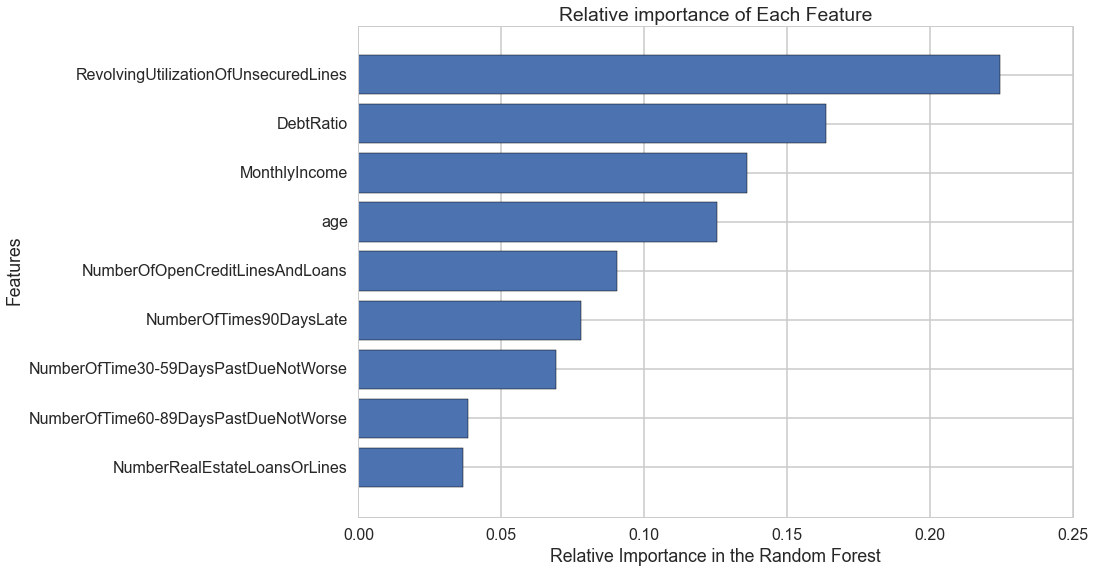

In [43]:
importance_list = clfForest.feature_importances_
name_list = train_data.columns[1:-1]
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [44]:
from sklearn.metrics import roc_curve, auc

In [45]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.5f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

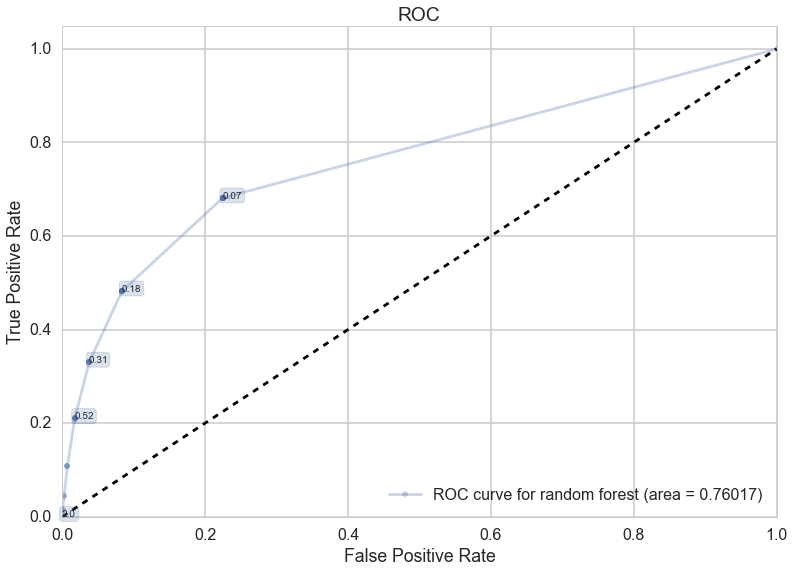

In [46]:
make_roc("random forest",clfForest, ytest, Xtest, None, labe=10)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30,60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       train_data, Xnames, 'SeriousDlqin2yrs', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/apple/anaconda/envs/Py27/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 59, 'max_depth': 5} 0.287202546624 [mean: 0.18077, std: 0.01708, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.18397, std: 0.01529, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.18422, std: 0.01527, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.18800, std: 0.01742, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.19705, std: 0.01379, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.20253, std: 0.01448, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.20074, std: 0.01180, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.20571, std: 0.01593, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.20769, std: 0.01383, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.20805, std: 0.01325, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.21177, std: 0.01472, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.21298, std: 0.01363, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.21287, std: 0.01424, params: {'n_e

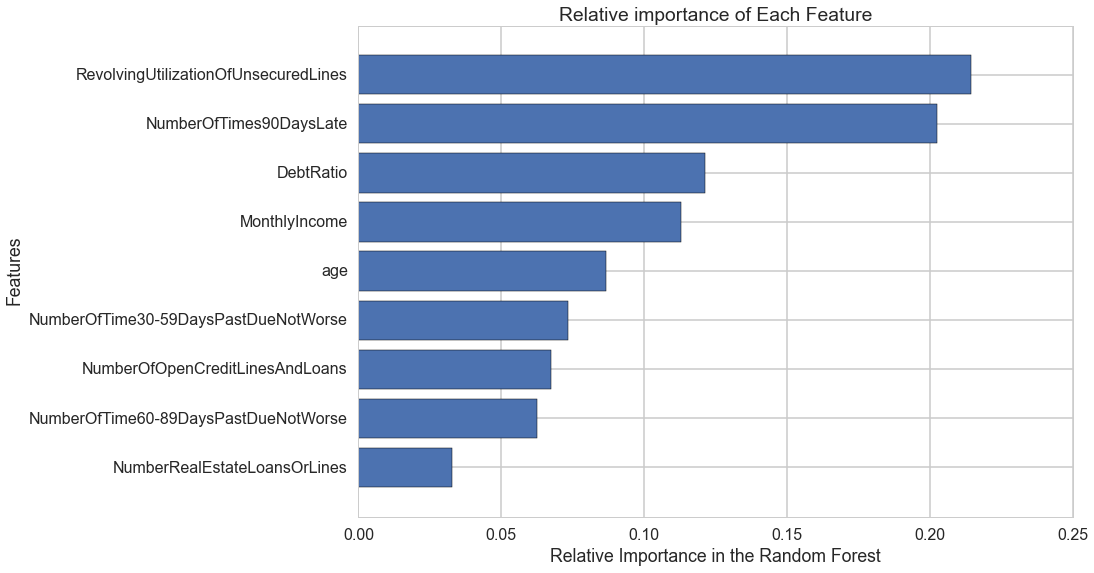

In [48]:
importance_list = clfGB.feature_importances_
name_list = train_data.columns[1:-1]
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

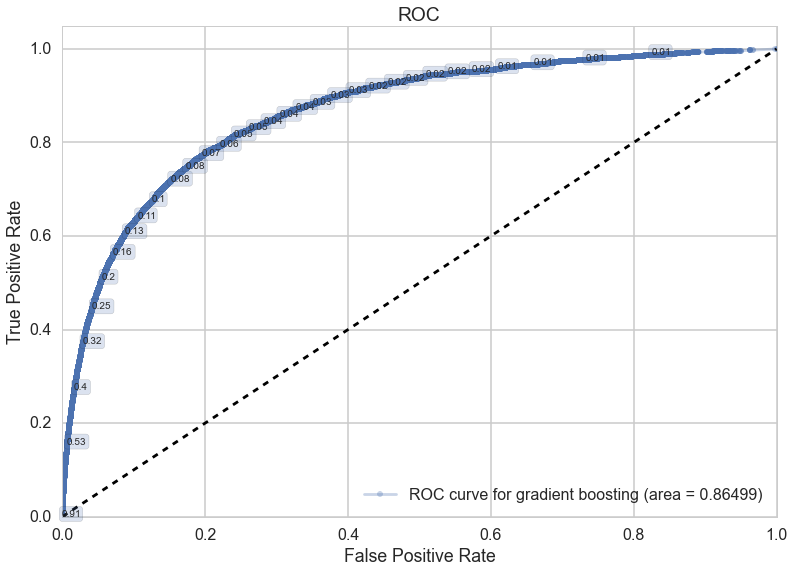

In [49]:
make_roc("gradient boosting",clfGB, ytest, Xtest, None, labe=1000)

Looking good! Quite close to the Kaggle benchmark, let's consider the cost problem by plotting the average cost(Y) with percentage of highest possibility samples(X). For example, x = 0.1 means we take the records with top 10 percentile of probability as positive, and the y value on the curve with indicate the average cost of all the customers. In the graph output below, we can find that with the threshold of 0.16, about 10 percent of records are labeled as positive, with which has an average cost of 58.

In [50]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    return ax

2015-12-01 19:36:20.594798


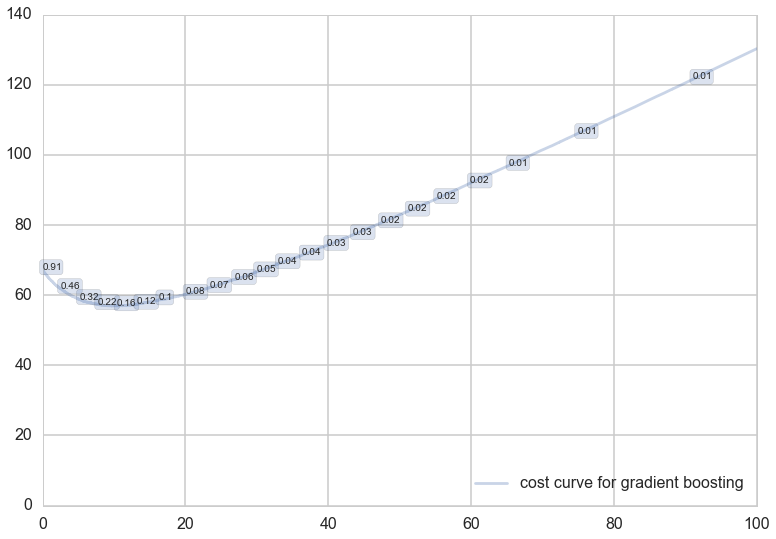

In [51]:
ax = plot_cost("gradient boosting",clfGB, ytest, Xtest, cost, threshold=True, labe=1500)
from datetime import datetime
after = datetime.now()
print after

Why random forest did not work well? This is what I think: In bootstrap progress, since the dataset is highly imbalanced, the samples are highly homogeneous, making trees in the forest look alike. After that the trees are pruned to avoid overfitting, which also reduce their predicting power. 

These two problems are quite hard to be solved by parameter optimization. We could possibly down sample the negative samples, so there is still space for improvement.

What are the things we can do to further improve the model?

1.Have a better knowledge on conversion rate of precautions;

2.Keep digging the realtionship between missing data, outliers and target values;

3.Feature engineering based on the distribution of the data;

4.Apply deep learning models after regularizing the features.